In [ ]:
import numpy as np

import random as rd

statespace_size = 7

# north, east, south, west are the valid actions each agent can take
actions = ['n', 'w', 'e', 's']

def dir(start,end): #direction vector for two grid positions
    (x,y)=start
    (a,b)=end
    return ((a-x, b-y))

class Agent:

    def __init__(self, id, pos, reached_a, loc_a):

        self.id = id
        self.pos = pos

        # indicates if agent has already reached A in a run
        self.reached_a = reached_a

        if(loc_a == pos):
            self.reached_a = True

        self.num_collisions = 0
        self.num_steps = 0
        self.cycles = 0
    
    def _reset(self, pos, reached_a, loc_a):

        self.pos = pos
        self.reached_a = reached_a

        if(loc_a == pos):
            self.reached_a = True

        self.done = False
        self.num_collisions = 0
        self.num_steps = 0
        self.cycles = 0


class GridWorld:

    def __init__(self, n = 5, m = 5, loc_a = (0,0), loc_b = (4, 4), agents=None):
        
        # validations: n and m must be strictly positive, loc_a and b should be valid and not equal, number of agents shouldn't exceed the number of cells in the grid

        self.n = n
        self.m = m

        self.loc_a = loc_a
        self.loc_b = loc_b

        # each grid cell has NoneType objects by default
        self.grid = np.empty(shape=(n, m), dtype=object)

        # initialise every cell as an empty list
        for i in range(n):
            for j in range(m):
                self.grid[i, j] = []

        # add agents to some cells as list elements
        for agent in agents:
            self.grid[agent.pos[0], agent.pos[1]].append(agent)

    def _reset(self, loc_a, loc_b, agents):

        self.loc_a = loc_a
        self.loc_b = loc_b

        # each grid cell has NoneType objects by default
        self.grid = np.empty(shape=(self.n, self.m), dtype=object)

        # initialise every cell as an empty list
        for i in range(n):
            for j in range(m):
                self.grid[i, j] = []

        # add agents to some cells as list elements
        for agent in agents:
            self.grid[agent.pos[0], agent.pos[1]].append(agent)
    
    # returns a dict where key is agent id and element is the Agent object
    def get_agents_dict(self):

        agents_dict = {}

        for i in range(self.n):
            for j in range(self.m):
                if len(self.grid[i, j]) > 0:
                    for agent in self.grid[i, j]:
                        agents_dict[ agent.id ] = agent
        
        return agents_dict

    # should get an agent-specific game state in an np array representation to be used in training the DQN
    def get_np_state_for_agent(self, agent):

        # state space = agent_x X agent_y X loc_ax X loc_ay X loc_bx X loc_by X reached_a X neighbourhood_state (8 booleans)

        state = [agent.pos[0], agent.pos[1]] + list(dir(self.loc_a,agent.pos)) \
            + list(dir(self.loc_b,agent.pos)) + [int(agent.reached_a)]

        return np.array(state).reshape(1, statespace_size)


    # attempt to perform an action for a given agent if action is valid/permissible.
    # after performing this action, agent should be rewarded/penalised appropriately.
    # returns the reward/penalty
    def attempt_action_for_agent(self, agent, action):

        ## rewards/penalties

        boundary_pen = -24
        a_reach_rew = 24
        b_reach_rew = 24
        collision_pen = -24
        per_cycle_rew = 0
        step_pen = -0.5

        new_pos = agent.pos
        agent.num_steps += 1

        ## check if action is valid (maybe penalise for hitting a boundary)

        # boundary conditions

        match action:
            
            # agent.pos[0] - x coordinate - vertical conditions (north/south)
            # agent.pos[1] - y coordinate - horizontal conditions

            case 'n':

                if agent.pos[0] == 0:
                    return boundary_pen
                
                else:
                    new_pos = (agent.pos[0] - 1, agent.pos[1])

            case 'e':

                if agent.pos[1] == self.m - 1:
                    return boundary_pen
                
                else:
                    new_pos = (agent.pos[0], agent.pos[1] + 1)
            
            case 's':

                if agent.pos[0] == self.n - 1:
                    return boundary_pen
                
                else:
                    new_pos = (agent.pos[0] + 1, agent.pos[1])
            
            case 'w':

                if agent.pos[1] == 0:
                    return boundary_pen
                
                else:
                    new_pos = (agent.pos[0], agent.pos[1] - 1)

        ## perform the action

        self.grid[ agent.pos[0], agent.pos[1] ].remove(agent)
        self.grid[ new_pos[0], new_pos[1] ].append(agent)
        agent.pos = new_pos

        loc_reach_rew = step_pen

        ## check if agent reached A or B and reward
        if ( new_pos == self.loc_a ) and ( not agent.reached_a ):
            agent.reached_a = True
            agent.cycles += 1
            loc_reach_rew = a_reach_rew + (agent.cycles * per_cycle_rew)
        
        elif ( new_pos == self.loc_b ) and ( agent.reached_a ):
            # reached_a gets set to false as we need the agents to learn an infinite behavior - the agent will now head back to A
            agent.reached_a = False
            agent.cycles += 1
            loc_reach_rew = b_reach_rew + ( agent.cycles * per_cycle_rew )
        
        ## else: check head-on collisions and penalise
        else:
            agents_in_cell = self.grid[new_pos[0], new_pos[1]]
            for agent2 in agents_in_cell:
                if agent2.reached_a != agent.reached_a:
                    agent.num_collisions += 1
                    loc_reach_rew = collision_pen
                    break

        ## if it was a normal step, reward -1
        return loc_reach_rew

    def display(self):

        print(' -' + '-' * self.m * 3)

        for i in range(self.n):

            print('| ', end='')
            for j in range(self.m):

                if self.loc_a[0] == i and self.loc_a[1] == j:
                    print(' A ', end='')
                
                elif self.loc_b[0] == i and self.loc_b[1] == j:
                    print(' B ', end='')

                elif len(self.grid[i, j]) == 0:
                    print('   ', end='')

                if len(self.grid[i, j]) > 0:

                    if ((i, j) != self.loc_a) and ((i, j) != self.loc_b):

                        print(f'*{str(len(self.grid[i, j]))} ', end='')
                    
            
            print('|')
        
        print(' -' + '-' * self.m * 3)

        print(f"* followed by a number indicates the presence of a number of agents in that cell.\nagents at A and B are not indicated.\n")

        # debug print agents in the grid
        print("agents in the grid:")
        for id, ag in self.get_agents_dict().items():
            print(f"id: {id} pos: {ag.pos} is_loaded: {ag.reached_a}")
        print()

# initialise a number of agents randomly in either loc_a or loc_b
# loc_a and loc_b are coords of the form (x,y)
# returns a list of created agents of ids from 1 to num_agents
# and the first agent (id 1) is always placed at loc_b
def init_agents(num_agents, loc_a, loc_b):

    agents = []

    # for debugging only
    # debug_locs = [loc_a, loc_b, (loc_a[0] - 1, loc_a[1]), (loc_a[0] + 1, loc_a[1]), (loc_b[0] - 1, loc_b[1])]

    for i in range(num_agents):

        if i == 0:
            # at least one agent must begin at B
            agents.append( Agent(i+1, loc_b, False, loc_a) )
            continue
        
        # # debug force 2 at A
        # if i == 1:
        #     agents.append( Agent(i+1, loc_a, True, loc_a) )
        #     continue

        # rd_loc for each subsequent agent
        rd_loc = rd.choice([loc_a, loc_b])
        
        # debug
        # rd_loc = rd.choice(debug_locs)

        agents.append( Agent(i+1, rd_loc, (rd_loc==loc_a), loc_a) )
    
    return agents

def init_agents_random(n, m, num_agents, loc_a):

    agents = []

    for i in range(num_agents):
        pos = ( rd.randint(0, n-1), rd.randint(0, m-1) )
        agents.append( Agent( i+1, pos, rd.choice([True, False]), loc_a ))
    
    return agents

if __name__ == '__main__':

    n = 5
    m = 5
    num_agents = 4
    
    loc_a = (1,1)
    loc_b = (3,3)
    agents = init_agents(num_agents, loc_a, loc_b)

    gw = GridWorld(n, m, loc_a, loc_b, agents)
    gw.display()

    # debug print agents in the grid
    print("agents in the grid:")
    for id, ag in gw.get_agents_dict().items():
        print(id, ag.pos, ag.reached_a, end=' | ')
    print()

    # print("agent 1 np state:", gw.get_np_state_for_agent(agents[0]))
    # print()
    
    # print("agent 2 np state:", gw.get_np_state_for_agent(agents[1]))

    print(gw.attempt_action_for_agent(agents[0], 'w'))
    gw.display()

    print(gw.attempt_action_for_agent(agents[0], 's'))
    gw.display()




In [ ]:
# %%
import torch
import copy

# %% [markdown]
# You need to instantiate the constant for the size of the state space below. This will be used as the size of the input tensor for your Q-network

# %%

learning_rate = 2e-4

# debug
global_loc_a = (1,0)
global_loc_b = (4,4)

# %% [markdown]
# The function "prepare_torch" needs to be called once and only once at the start of your program to initialise PyTorch and generate the two Q-networks. It returns the target model (for testing).

# %%
def prepare_torch():
  global statespace_size
  global model, model2
  global optimizer
  global loss_fn
  global learning_rate
  l1 = statespace_size
  l2 = 64
  l3 = 64
  l4 = 4
  model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4))
  model2 = copy.deepcopy(model)
  model2.load_state_dict(model.state_dict())
  loss_fn = torch.nn.MSELoss()
  # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model2

# def TD_target(reward, gamma, done, qMax):
#     # done was an arg in skeleton
# #   target = reward + gamma*(1-done)*qMax
#     target = reward + gamma*(1-done)*qMax
#     return target

# calculates TD targets in batches.
def TD_target(rewards, gamma, dones, q_max_next_states):

    # Ensure inputs are tensors for consistency and operations
    if not isinstance(rewards, torch.Tensor):
        # print(type(rewards))
        rewards = torch.tensor(rewards, dtype=torch.float32)
    if not isinstance(dones, torch.Tensor):
        dones = torch.tensor(dones, dtype=torch.float32)
    if not isinstance(q_max_next_states, torch.Tensor):
        q_max_next_states = torch.tensor(q_max_next_states, dtype=torch.float32)

    targets = rewards + gamma * (1 - dones) * q_max_next_states
    return targets

# %% [markdown]
# The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.

# %%
def update_target():
  global model, model2
  model2.load_state_dict(model.state_dict())

# %% [markdown]
# The function "get_qvals" returns a numpy list of qvals for the state given by the argument _based on the prediction network_.

# %%
def get_qvals(state):
  state1 = torch.from_numpy(state).float()
  qvals_torch = model(state1)
  qvals = qvals_torch.data.numpy()
  return qvals

# %% [markdown]
# The function "get_maxQ" returns the maximum q-value for the state given by the argument _based on the target network_.

# calculates the maximum Q-values for a batch of next states.
def get_maxQ(next_states):

    next_states_tensor = torch.from_numpy(next_states).float()  # Convert to PyTorch tensor
    with torch.no_grad():  # Important: Disable gradient calculation
        q_values = model2(next_states_tensor)  # Shape: (batch_size, 1, action_space_size)
        max_q_values, _ = torch.max(q_values.squeeze(1), dim=1)  # Squeeze the middle dim, then get max
    return max_q_values.numpy()  # Convert back to NumPy array

# %% [markdown]
# The function "train_one_step_new" performs a single training step. It returns the current loss (only needed for debugging purposes). Its parameters are three parallel lists: a minibatch of states, a minibatch of actions, a minibatch of the corresponding TD targets and the discount factor.

# %%
def train_one_step(states, actions, targets, gamma):
  # pass to this function: state1_batch, action_batch, TD_batch
  global model, model2
  state1_batch = torch.cat([torch.from_numpy(s).float() for s in states])
  action_batch = torch.LongTensor(actions)
  Q1 = model(state1_batch)
  X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
  Y = torch.tensor(targets)
  loss = loss_fn(X, Y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item()

# %%



In [36]:
from grid_world import *
from stage2skeletonv3 import *
import random as rd

from collections import deque
from IPython.display import clear_output

losses=[]
collisions_lst = []
ep_rewards = []
cycles_lst = []
eps_lst = []
action_set = {0: 'n', 1: 'w', 2: 'e', 3: 's'}
j= 0
collisions = 0
total_cycles = 0
i = 0 # epoch count

n = 5
m = 5

def train():

    global losses, collisions_lst, action_set, model, j, collisions, total_cycles, i, ep_rewards, cycles_lst, eps_lst, n, m

    gamma = 0.999
    # epsilon = 1.0
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.99997
    current_loss = 0

    epochs = 2600
    mem_size = 5000
    batch_size = 200
    replay = deque(maxlen=mem_size)
    max_moves = 80
    h = 0
    sync_freq = 200
    j=0
    # rewards=[]

    model = prepare_torch()

    num_agents = 4

    total_cycles = 0
    collisions = 0

    # initialise all configs and agents to optimize training performance

    loc_as = []
    loc_bs = []
    agents_each_epoch = []
    gws = []

    for i in range(epochs):
        
        loc_a = (rd.randint(0,n-1), rd.randint(0,m-1))
        # loc_a = global_loc_a
        # loc_b = (rd.randint(0,n-1), rd.randint(0,m-1))

        # loc_a = (0,3)
        # fix B
        loc_b = global_loc_b

        # ensuring loc_b and loc_a aren't equal
        while loc_b == loc_a:
            loc_b = rd.randint(0,n-1), rd.randint(0,m-1)
        
        loc_as.append(loc_a)
        loc_bs.append(loc_b)
        agents = init_agents( num_agents, loc_a, loc_b )
        agents_each_epoch.append( agents )
        # agents_each_epoch.append( init_agents_random( n, m, num_agents, loc_a ) )

        gws.append( GridWorld(n, m, loc_a, loc_b, agents) )

    # main loop 

    for i in range(epochs):

        loc_a = loc_as[i]
        loc_b = loc_bs[i]

        agents = agents_each_epoch[i]

        # a_b_switches = {}
        # for agent in agents:
        #     a_b_switches[agent.id] = 0

        gw = gws[i]

        steps = 0
        loop = True
        episode_reward = 0
        epoch_collisions = 0
        epoch_cycles = 0

        while loop and (steps < max_moves):

            # # change loop_agents to random order
            loop_agents = agents

            # rd.shuffle(loop_agents)
            
            for agent in loop_agents:

                # print(steps)
                # init_reached_a = agent.reached_a

                state1 = gw.get_np_state_for_agent(agent)
                steps += 1
                j += 1
                qvals = get_qvals(state1)

                if (rd.random() < epsilon):
                    action_ = rd.randint(0,3)
                else:
                    action_ = np.argmax(qvals)
                
                action = action_set[action_]
                
                reward = gw.attempt_action_for_agent(agent, action)

                state2 = gw.get_np_state_for_agent(agent)

                episode_reward += reward

                # if we consider pickup and dropoff as terminal condition - we dont - because agents need to learn infinite behavior
                # done = True if (a_b_switches[agent.id] >= 2) else False # both pickup and delivery at least once
                
                # if we consider 1 collision 
                # or num_steps over 25
                # as a terminal condition
                done = False
                if (agent.num_collisions > 0) or (agent.num_steps > 25):
                    done = True
                    # loop = False

                exp = (state1, action_, reward, state2, done)
                replay.append(exp)


                if (len(replay) > batch_size) and (j % 4 == 0):

                    # minibatch = rd.sample(replay, batch_size)
                    # states = [s1 for (s1,_,_,_,_) in minibatch]
                    # actions = [a for (_,a,_,_,_) in minibatch]
                    # targets = [TD_target(r, gamma, done, get_maxQ(s2)) for (_,_,r,s2,_) in minibatch]
                    # current_loss = train_one_step(states, actions, targets, gamma)
                    # losses.append(current_loss)
                    
                    minibatch = rd.sample(replay, batch_size)  # Sample as a list of tuples
                    states = np.stack([exp[0] for exp in minibatch])
                    actions = np.array([exp[1] for exp in minibatch], dtype=int)
                    rewards = np.array([exp[2] for exp in minibatch], dtype=np.float32)
                    next_states = np.stack([exp[3] for exp in minibatch])
                    dones = np.array([exp[4] for exp in minibatch], dtype=int)
                    q_max_next_states = get_maxQ(next_states)
                    # q_max_next_states = model2(next_states).max(dim=1).values 
                    targets = TD_target(rewards, gamma, dones, q_max_next_states)
                    current_loss = train_one_step(states, actions, targets, gamma)
                    losses.append(current_loss)

                if j % sync_freq == 0:
                    print(i, "cycles:", total_cycles, " loss:", current_loss, "total collisions:", collisions, "epoch_collisions:", epoch_collisions)
                    print(f"episode_reward: {episode_reward} steps: {steps} epoch_cycles: {epoch_cycles} epsilon: {epsilon}")
                    print()
                    clear_output(wait=True)
                    update_target()
            
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            epoch_collisions = sum([agent.num_collisions for agent in loop_agents])
            epoch_cycles = sum([agent.cycles for agent in loop_agents])

            if steps > max_moves:
                loop = False
                steps = 0
                break

        for agent in agents:
            collisions += epoch_collisions
        
        ep_rewards.append(episode_reward)
        collisions_lst.append(epoch_collisions)
        cycles_lst.append(epoch_cycles)
        total_cycles += epoch_cycles
        eps_lst.append(epsilon)
        
        # clear_output(wait=True)  

    print(f"total epochs: {i}, total steps in training: {j}, total collisions: {collisions}, total a/b switches: {total_cycles}")

train()

# import cProfile
# cProfile.run("train()")


total epochs: 2599, total steps in training: 208000, total collisions: 33696, total a/b switches: 20865


In [37]:
print(f"total epochs: {i}, total steps in training: {j}, total collisions: {collisions}, total a/b switches: {total_cycles}")
print(f"lr: {learning_rate}")

total epochs: 2599, total steps in training: 208000, total collisions: 33696, total a/b switches: 20865
lr: 0.0002


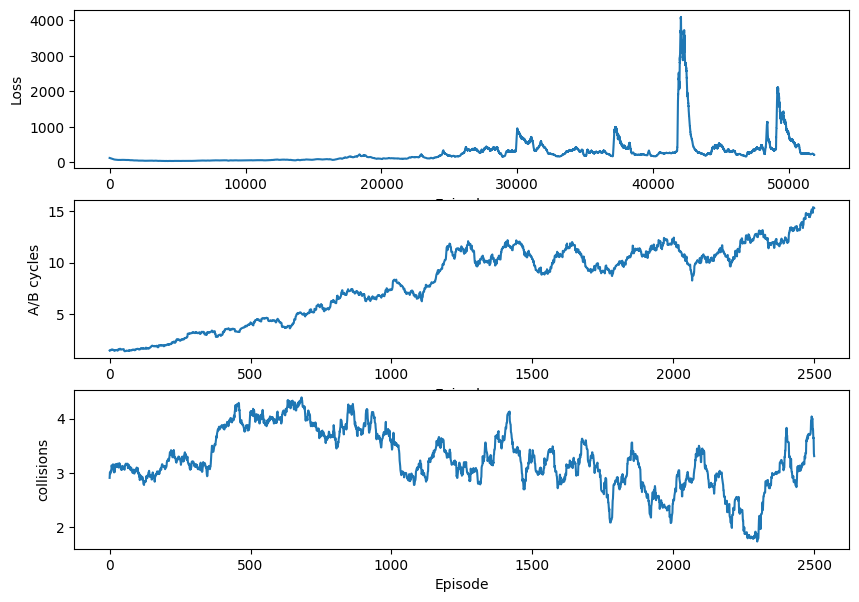

In [38]:
def moving_averages(arr, window_size):
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:
        window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

from matplotlib import pylab as plt

# plt.xlabel("Episode",fontsize=22)
# plt.ylabel("Loss",fontsize=22)
# plt.plot(np.array(losses))
# plt.figure(figsize=(10,7))

_, axs = plt.subplots(3, 1, figsize = (10,7))

# axs[0].plot(np.array(losses))
# axs[0].set_xlabel("Episode",fontsize=18)
# axs[0].set_ylabel("Loss",fontsize=18)

axs[0].plot(np.array(moving_averages(losses, 100)))
axs[0].set_xlabel("Episode",fontsize=10)
axs[0].set_ylabel("Loss",fontsize=10)

# axs[1].set_xlabel("Episode", fontsize=18)
# axs[1].set_ylabel("A/B switches", fontsize=18)
# axs[1].plot(np.array(a_b_switches_lst))

axs[1].set_xlabel("Episode", fontsize=10)
axs[1].set_ylabel("A/B cycles", fontsize=10)
axs[1].plot(np.array(moving_averages(cycles_lst, 100)))

# axs[2].set_xlabel("Episode", fontsize=18)
# axs[2].set_ylabel("collisions", fontsize=18)
# axs[2].plot(np.array(collisions_lst))

axs[2].set_xlabel("Episode", fontsize=10)
axs[2].set_ylabel("collisions", fontsize=10)
axs[2].plot(moving_averages(collisions_lst, 100))

plt.show()

Text(0, 0.5, 'Epsilon')

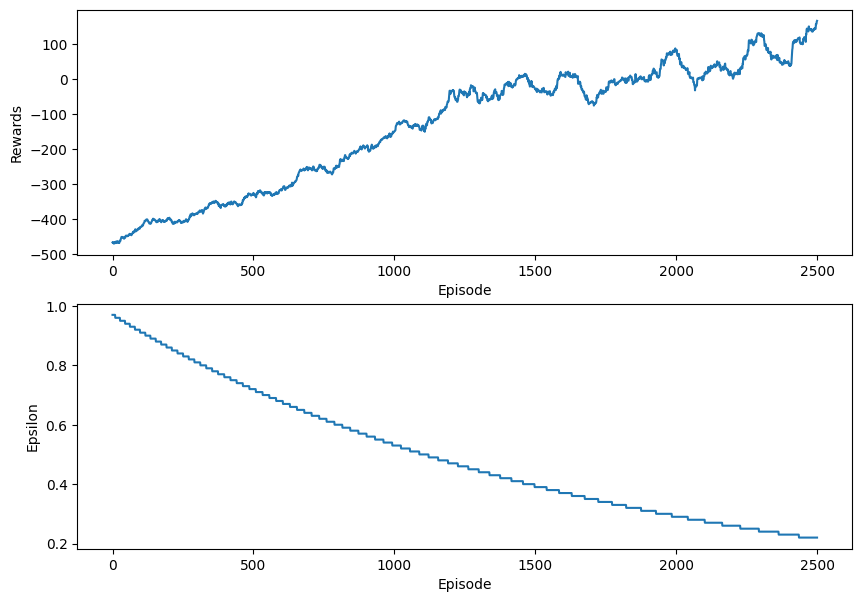

In [39]:

_, axs = plt.subplots(2, 1, figsize = (10,7))

axs[0].plot(np.array(moving_averages(ep_rewards, 100)))
axs[0].set_xlabel("Episode",fontsize=10)
axs[0].set_ylabel("Rewards",fontsize=10)

axs[1].plot(np.array(moving_averages(eps_lst, 100)))
axs[1].set_xlabel("Episode",fontsize=10)
axs[1].set_ylabel("Epsilon",fontsize=10)

In [40]:
def test_once(model, loc_a, loc_b, display=True):

    n = 5
    m = 5

    max_steps = 25

    # 1st agent always begins at B
    agents = init_agents(4, loc_a, loc_b)

    gw = GridWorld(n, m, loc_a, loc_b, agents)

    focal_agent_idx = 0

    states_ = [gw.get_np_state_for_agent(agent).reshape(1, statespace_size) for agent in agents]
    states = [torch.from_numpy(state_).float() for state_ in states_]

    if display:
        print("initial state:")
        gw.display()
        print("focal agent is", agents[focal_agent_idx].id)

    for s in range( (len(agents)*25) + 1 ):

        for idx in range(len(agents)):

                qval = model(states[idx])
                qval_ = qval.data.numpy()
                action_ = np.argmax(qval_)
                action = action_set[action_]

                rew = gw.attempt_action_for_agent(agents[idx], action)

                if display:
                    print(f"agent {agents[idx].id} took action {action} and got rewarded {rew}")
                    print(gw.display())
                
                state_ = gw.get_np_state_for_agent(agents[idx]).reshape(1, statespace_size)
                state = torch.from_numpy(state_).float()
                states[idx] = state
        
        # whichever if condition is met first will return
        if (agents[focal_agent_idx].num_steps > max_steps):
            if display:
                print("test unsuccessful - too many steps")
            return False
        
        if (agents[focal_agent_idx].num_collisions > 0):
            if display:
                print("test unsuccessful - focal agent collided with an agent of the opposite type")
            return False

        if (agents[focal_agent_idx].reached_a):
            if display:
                print(f"test success - focal agent {agents[focal_agent_idx].id} reached A without collisions in under 25 steps")
            return True

    # ideally this line must never execute - if conditions should handle everything
    return False


In [41]:
loc_a = ( rd.randint(0,4), rd.randint(0,4) )
# loc_b = ( rd.randint(0,4), rd.randint(0,4) )

# loc_a = (0,3)
# loc_a = global_loc_a
# fixed B
loc_b = global_loc_b

test_once(model, loc_a, loc_b, True)

initial state:
 ----------------
|                |
|           A    |
|                |
|                |
|              B |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
2 (1, 3) True | 3 (1, 3) True | 1 (4, 4) False | 4 (4, 4) False | 
focal agent is 1
agent 1 took action w and got rewarded -0.5
 ----------------
|                |
|           A    |
|                |
|                |
|          *1  B |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
2 (1, 3) True | 3 (1, 3) True | 1 (4, 3) False | 4 (4, 4) False | 
None
agent 2 took action e and got rewarded -0.5
 ----------------
|                |
|           A *1 |
|                |
|                |
|          *1  B |
 ----------------
* followed by a number indicates the presence of a number of agents 

True

In [42]:
def test_stats(model):
  max_games = 1000
  wins = 0
  for i in range(max_games):
      
      loc_a = ( rd.randint(0,4), rd.randint(0,4) )
      # loc_a = global_loc_a
      # loc_b = ( rd.randint(0,4), rd.randint(0,4) )

      # fixed B
      loc_b = loc_b = global_loc_b

      while loc_b == loc_a:
         loc_b = ( rd.randint(0,4), rd.randint(0,4) )

      win = test_once(model, loc_a, loc_b, display=False)
      if win:
          wins += 1

  win_perc = float(wins) / float(max_games)
  print("Games played: {0}, # of wins: {1}".format(max_games,wins))
  print("Win percentage: {}".format(win_perc))


test_stats(model)

Games played: 1000, # of wins: 896
Win percentage: 0.896
